# Advanced Data Analysis 23/24: group project

By delivering this notebook, we confirm that the code presented was developed by the following students.

## Student 1: Joao Penedo, 61246
## Student 2: Martim Esteves, 46953


**In the solutions for exercises 1 to 4 you should include necessarily one solution using Pandas/scikit learn and one using Spark.**

Some useful links:
* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

Run the following cell just to check if it is running in COLAB.

In [1]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [2]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint
!pip uninstall --yes protobuf tensorflow tensorboard; pip install cupy-cuda11x
!pip install cudf-cu11 dask-cudf-cu11 cuml-cu11 cugraph-cu11 --extra-index-url https://pypi.nvidia.com


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 119 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.9+9-1~22.04 [48.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.9+9-1~22.04 [71.1 MB]
Fetched 119 MB in 2s (54.1 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 120899 

## Setup

The following cell will import the used packages.

In [3]:
from zipfile import ZipFile
import time
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *

from sklearn.preprocessing import StandardScaler as sklearnStandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

import cudf
import cuml.cluster
from cuml.metrics.cluster import silhouette_score as cusilhouette_score
from cuml.preprocessing import StandardScaler as cuStandardScaler
import cupy as cp

import warnings
warnings.filterwarnings('ignore')


## Dataset

In this project, you will be asked to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/sbe2324ada

Mounted at /content/drive
0-68732.csv.gz	      260001-270000.csv.gz  320001-329999.csv.gz  360001-364000.csv.gz
190001-209999.csv.gz  270001-280000.csv.gz  330000-337000.csv.gz  364001-367000.csv.gz
210000-224000.csv.gz  280001-290000.csv.gz  337001-343000.csv.gz  367001-369999.csv.gz
224001-234000.csv.gz  290001-300000.csv.gz  343001-349000.csv.gz  btc_price.csv
234001-247000.csv.gz  300001-310000.csv.gz  349001-354000.csv.gz  labels
247001-260000.csv.gz  310001-320000.csv.gz  354001-360000.csv.gz


In [5]:
#DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
DATASET_DIR = "/content/drive/MyDrive/sbe2324ada"

# Small dataset
# TXDATA_FILE = "0-68732.csv.gz"
# Larger dataset
TXDATA_FILE = "234001-247000.csv.gz"


# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"



### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

In [6]:
# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    date_cols = ["Time"]
    path = os.path.join(DATASET_DIR, filename)
    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz


KeyboardInterrupt: ignored

In [ ]:
# Dumps basic infomation using Spark Pandas API
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    df = ps.read_csv( path,compression="gzip")
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


In [ ]:
# Dumps basic infomation using Spark Dataframe load
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    mySchema = StructType([
        StructField("TxId", StringType()),
        StructField("Height", IntegerType()),
        StructField("Input", StringType()),
        StructField("Output", StringType()),
        StructField("Sum", StringType()),
        StructField("Time", TimestampType()),
    ])

    dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
    dataset.createOrReplaceTempView("data")

    statistics = spark.sql( """SELECT COUNT( *) AS num_transactions,
                                  MIN( Height) AS first_block,
                                  MAX( Height) AS last_block,
                                  MIN( Time) AS first_time,
                                  MAX( Time) AS last_time
                                  FROM data""")
    statistics.show()


### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [ ]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)



TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value             object
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


We repeat the same computation in Spark SQL, creating views with the same names.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()


root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [ ]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv( path,parse_dates=date_cols)
print(priceDF)
priceDF.dtypes


           Date    Price
0    2009-01-15      0.1
1    2009-01-16      0.1
2    2009-01-17      0.1
3    2009-01-18      0.1
4    2009-01-19      0.1
...         ...      ...
5417 2023-11-15  37874.9
5418 2023-11-16  36161.2
5419 2023-11-17  36595.4
5420 2023-11-18  36568.6
5421 2023-11-19  36792.1

[5422 rows x 2 columns]


Date     datetime64[ns]
Price           float64
dtype: object

### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


## Exercise 0 [1 point]

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### Pandas code

In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


                                      cnt_in   cnt_out       cnt
1dice97ECuByXAvqXpaYzSaQuPVvrtmz6   204269.0  203877.0  408146.0
1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp   201330.0  200994.0  402324.0
1dice9wcMu5hLF4g81u8nioL5mmSHTApw   101125.0  101016.0  202141.0
1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx    69606.0   67552.0  137158.0
1dice6YgEVBf88erBFra9BHf6ZMoyvG88    67261.0   66801.0  134062.0
1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc    57153.0   57130.0  114283.0
1VayNert3x1KzbpzMGt2qdqrAThiRovi8    54331.0   54493.0  108824.0
1dice7W2AicHosf5EL3GFDUVga7TgtPFn    53183.0   53066.0  106249.0
1CRZRBwfuwUaVSPJtd6DBuezbm7XPBHLa1   43548.0   43810.0   87358.0
1dice5wwEZT2u6ESAdUGG6MHgCpbQqZiy    42620.0   42009.0   84629.0
Runtime = 289.85430932044983


### Results (Pandas)

The time to process the small dataset was : **Runtime = 0.7575068473815918** seconds.

The time to process the large dataset was : **Runtime = 294.6047029495239** seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+------------------------------------+------+------+-------+
|addr                                |cnt   |cnt_in|cnt_out|
+------------------------------------+------+------+-------+
|'1dice97ECuByXAvqXpaYzSaQuPVvrtmz6' |408146|204269|203877 |
|'1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp' |402324|201330|200994 |
|'1dice9wcMu5hLF4g81u8nioL5mmSHTApw' |202141|101125|101016 |
|'1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx' |137158|69606 |67552  |
|'1dice6YgEVBf88erBFra9BHf6ZMoyvG88' |134062|67261 |66801  |
|'1diceDCd27Cc22HV3qPNZKwGnZ8QwhLTc' |114283|57153 |57130  |
|'1VayNert3x1KzbpzMGt2qdqrAThiRovi8' |108824|54331 |54493  |
|'1dice7W2AicHosf5EL3GFDUVga7TgtPFn' |106249|53183 |53066  |
|'1CRZRBwfuwUaVSPJtd6DBuezbm7XPBHLa1'|87358 |43548 |43810  |
|'1dice5wwEZT2u6ESAdUGG6MHgCpbQqZiy' |84629 |42620 |42009  |
+------------------------------------+------+------+-------+

Runtime = 155.4530291557312


### Results (Spark)

The time to process the small dataset was : **Runtime = 1.2163200378417969** seconds.

The time to process the large dataset was : **Runtime = 147.28200769424438** seconds.



### Discussion:

Given your knowledge, discuss the possible reasons for the observed results.

Pandas works best with smaller datasets while pyspark works better with larger datasets. This is because pyspark allows for parallel processing but, with small datasets, the gains of the parallelization are offset by the overhead of the preparation for parallel processing.

## Exercise 1 [3 points]

This first group consists in computing some statistics on the infomration available in the dataset.

The smallest dataset might lead to strange results for some statistics. Use it while you are developing you project, but if you run into strange results, just use a larger one.




### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
start_time = time.time()

# date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

display(df.sort_values("Sum", ascending=False).head(10))

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

,TxId,Height,Input,Output,Sum,Time
501962,235448:0,235448,['159SCycgn8weAy2XGUEhD6V1RTFni7E3iq'],"[['14FUkxnRMXexi95uGEYUWH5tTE7RvLVaeJ', 1000.0...",35323.801000,2013-05-10 08:04:06
502382,235449:0,235449,['159SCycgn8weAy2XGUEhD6V1RTFni7E3iq'],"[['1JX5hS3HyVT3VwnEgvoPLVu6ujPFH7BvrY', 942.0]...",34323.800000,2013-05-10 08:07:00
502718,235450:49,235450,['159SCycgn8weAy2XGUEhD6V1RTFni7E3iq'],"[['14FUkxnRMXexi95uGEYUWH5tTE7RvLVaeJ', 884.0]...",33381.799000,2013-05-10 08:10:16
942389,236542:0,236542,['159SCycgn8weAy2XGUEhD6V1RTFni7E3iq'],"[['1M8Zs88j3T59opujTE1zysXgreDmM9dhU9', 1000.0...",32497.798900,2013-05-17 01:22:37
982608,236648:0,236648,['19StxPcpGtY4vcqLNoU76hBfKUwhUR7Xst'],"[['19Sx1WtfxgQtFCgja5DmgEpUSfFKvH1hr', 20000.0...",24036.418498,2013-05-17 18:28:33
555001,235577:0,235577,['1Hw8dtVC9bdxDz1su9Jx3GXTgjR75FJcMK'],"[['1JsVdtXZHKnuzUihEjCPyRm5EEcxRjWGEh', 21000....",22693.527437,2013-05-11 02:40:38
1671899,238759:0,238759,['19StxPcpGtY4vcqLNoU76hBfKUwhUR7Xst'],"[['1EyaBWouxGsPrNLWstRtUkQrj88djsFJeY', 21497....",21497.215238,2013-05-30 21:19:43
1870413,239509:1,239509,['19StxPcpGtY4vcqLNoU76hBfKUwhUR7Xst'],"[['1565b5YS8ev2r3XcedNchAo8f413o1fwM7', 21497....",21497.214238,2013-06-03 16:46:39
1872839,239516:5,239516,['1565b5YS8ev2r3XcedNchAo8f413o1fwM7'],"[['1DQzdwDK2mf5ekGEN6xCGCnoyWACJzXiJb', 12539....",21497.000000,2013-06-03 17:32:02
1672529,238762:9,238762,['1EyaBWouxGsPrNLWstRtUkQrj88djsFJeY'],"[['19StxPcpGtY4vcqLNoU76hBfKUwhUR7Xst', 21497.0]]",21497.000000,2013-05-30 21:37:01


Runtime = 51.408926010131836


### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

pathPrice = os.path.join(DATASET_DIR, BTCPRICE_FILE)
dfPrice = pd.read_csv(pathPrice)

df["Date"]=df["Time"].dt.strftime('%Y-%m-%d')

# display(df)
# display(dfPrice)
df = df.merge(dfPrice, on="Date", how="left")
df["SumUSD"] = df["Sum"]*df["Price"]

display(df.sort_values("SumUSD", ascending=False).head(10))

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

,TxId,Height,Input,Output,Sum,Time,Date,Price,SumUSD
501962,235448:0,235448,['159SCycgn8weAy2XGUEhD6V1RTFni7E3iq'],"[['14FUkxnRMXexi95uGEYUWH5tTE7RvLVaeJ', 1000.0...",35323.801000,2013-05-10 08:04:06,2013-05-10,117.7,4.157611e+06
502382,235449:0,235449,['159SCycgn8weAy2XGUEhD6V1RTFni7E3iq'],"[['1JX5hS3HyVT3VwnEgvoPLVu6ujPFH7BvrY', 942.0]...",34323.800000,2013-05-10 08:07:00,2013-05-10,117.7,4.039911e+06
942389,236542:0,236542,['159SCycgn8weAy2XGUEhD6V1RTFni7E3iq'],"[['1M8Zs88j3T59opujTE1zysXgreDmM9dhU9', 1000.0...",32497.798900,2013-05-17 01:22:37,2013-05-17,123.5,4.013478e+06
502718,235450:49,235450,['159SCycgn8weAy2XGUEhD6V1RTFni7E3iq'],"[['14FUkxnRMXexi95uGEYUWH5tTE7RvLVaeJ', 884.0]...",33381.799000,2013-05-10 08:10:16,2013-05-10,117.7,3.929038e+06
982608,236648:0,236648,['19StxPcpGtY4vcqLNoU76hBfKUwhUR7Xst'],"[['19Sx1WtfxgQtFCgja5DmgEpUSfFKvH1hr', 20000.0...",24036.418498,2013-05-17 18:28:33,2013-05-17,123.5,2.968498e+06
1357369,237745:0,237745,['19StxPcpGtY4vcqLNoU76hBfKUwhUR7Xst'],"[['14Jahb8ihTkGnZxAXgacint3nxjGv51AGc', 20000....",21036.476838,2013-05-24 21:12:25,2013-05-24,133.1,2.799955e+06
1671899,238759:0,238759,['19StxPcpGtY4vcqLNoU76hBfKUwhUR7Xst'],"[['1EyaBWouxGsPrNLWstRtUkQrj88djsFJeY', 21497....",21497.215238,2013-05-30 21:19:43,2013-05-30,128.8,2.768841e+06
1672529,238762:9,238762,['1EyaBWouxGsPrNLWstRtUkQrj88djsFJeY'],"[['19StxPcpGtY4vcqLNoU76hBfKUwhUR7Xst', 21497.0]]",21497.000000,2013-05-30 21:37:01,2013-05-30,128.8,2.768814e+06
1358535,237749:1,237749,['14Jahb8ihTkGnZxAXgacint3nxjGv51AGc'],"[['19StxPcpGtY4vcqLNoU76hBfKUwhUR7Xst', 19999....",20000.000000,2013-05-24 21:22:28,2013-05-24,133.1,2.662000e+06
1624002,238605:0,238605,"['1QCngDqaNb2cX3TzdsPTrVHiZvwLZ1CjUr', '1CZa7z...","[['1B1QnrLSm6edKNkp1yHKj4qt1RCzZ4mvEU', 20589....",20589.599900,2013-05-30 01:13:36,2013-05-30,128.8,2.651940e+06


Runtime = 49.16249322891235


### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


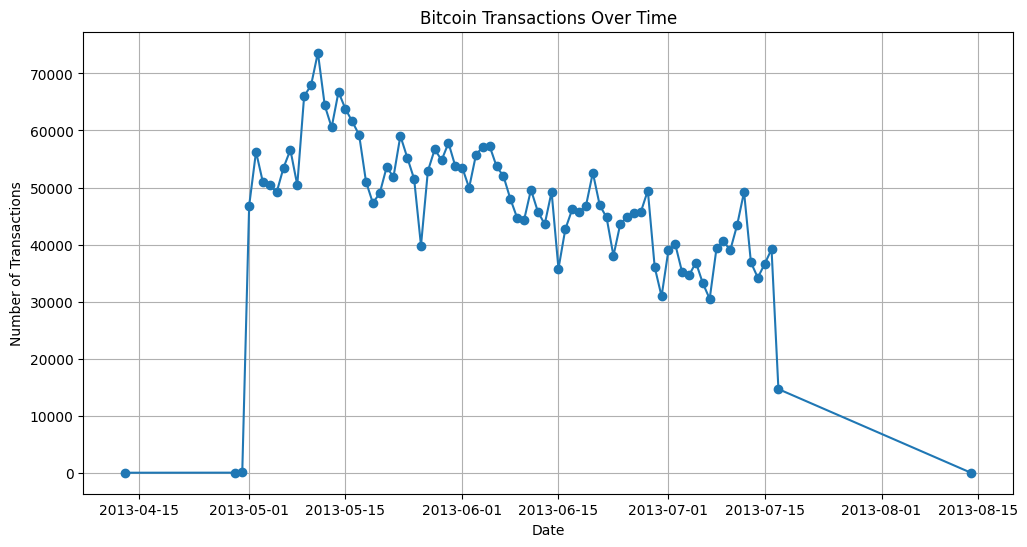

Runtime = 35.48821783065796


In [ ]:
start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

# Quantiles
Q1 = df['Time'].quantile(0.25)
Q3 = df['Time'].quantile(0.75)
IQR = Q3 - Q1

# Lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (df['Time'] >= lower_bound) & (df['Time'] <= upper_bound)
df_filtered = df[mask]

transactions_per_day = df_filtered.groupby(df_filtered['Time'].dt.date)['Time'].count()

plt.figure(figsize=(12, 6))
plt.plot(transactions_per_day.index, transactions_per_day.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Bitcoin Transactions Over Time')
plt.grid(True)
plt.show()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


,Date,Sum,SumUSD
0,2013-04-13,2.415950e+01,2.246834e+03
1,2013-04-29,7.104883e-01,1.023103e+02
2,2013-04-30,5.716231e+01,7.956994e+03
3,2013-05-01,1.216595e+06,1.416117e+08
4,2013-05-02,8.942025e+05,9.505372e+07
...,...,...,...
77,2013-07-14,5.596191e+05,5.282805e+07
78,2013-07-15,6.979798e+05,6.903020e+07
79,2013-07-16,9.482042e+05,9.207062e+07
80,2013-07-17,3.584198e+05,3.530435e+07


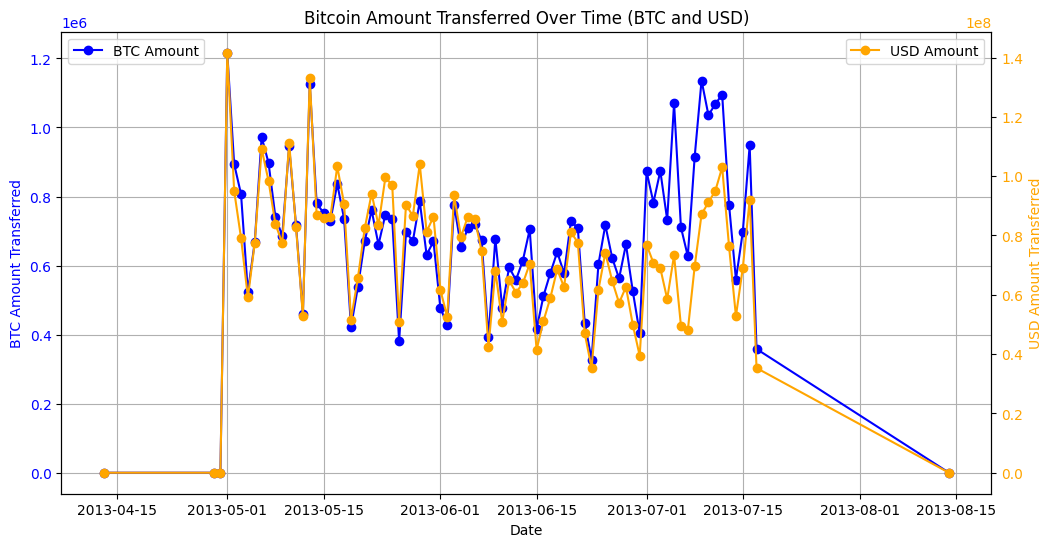

Runtime = 37.91038155555725


In [7]:
start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

pathPrice = os.path.join(DATASET_DIR, BTCPRICE_FILE)
dfPrice = pd.read_csv(pathPrice)

df["Date"]=df["Time"].dt.strftime('%Y-%m-%d')

# display(df)
# display(dfPrice)
df = df.merge(dfPrice, on="Date", how="left")
df["SumUSD"] = df["Sum"]*df["Price"]

# Quantiles
Q1 = df['Time'].quantile(0.25)
Q3 = df['Time'].quantile(0.75)
IQR = Q3 - Q1

# Lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (df['Time'] >= lower_bound) & (df['Time'] <= upper_bound)
df_filtered = df[mask]
df_filtered['Date'] = df_filtered['Time'].dt.date

ammount_per_day = df_filtered.groupby(["Date"], as_index=False)[["Date", "Sum", "SumUSD"]].sum()

display(ammount_per_day)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the BTC amount on the first y-axis
ax1.plot(ammount_per_day['Date'], ammount_per_day['Sum'], marker='o', linestyle='-', label='BTC Amount', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Amount Transferred', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a second y-axis for USD amount
ax2 = ax1.twinx()
ax2.plot(ammount_per_day['Date'], ammount_per_day['SumUSD'], marker='o', linestyle='-', label='USD Amount', color='orange')
ax2.set_ylabel('USD Amount Transferred', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.title('Bitcoin Amount Transferred Over Time (BTC and USD)')
plt.show()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

## Exercise 2 [4 points]

Assume you want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

Write the code to build these indices - for each index, print 5 lines.

**NOTE:** use the data from a single dataset file (even knowing that the value of the account balance would need to include processing all transactions).


##Measures
- Address account balance (mandatory) </br>
- top-3 commercial partners ("optional") </br>
- average transaction value </br>
</br>
- Transaction frequency </br>
- Number of commercial distinct partners </br>

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, sTXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")


In [ ]:
# Martim altered
# balanceSDF = spark.sql("""SELECT DISTINCT output as addr, SUM(value) as balance FROM output o JOIN (SELECT input, MAX(time) as max_time FROM input GROUP BY input) i on o.output = i.input and o.time>i.max_time GROUP BY addr ORDER BY addr""")
balanceSDF = spark.sql("""SELECT DISTINCT COALESCE(output, input) as addr, COALESCE(SUM(value), 0) as balance FROM output o FULL OUTER JOIN (SELECT input, MAX(time) as max_time FROM input GROUP BY input) i on o.output = i.input and o.time>=COALESCE(i.max_time, FROM_UNIXTIME(0)) GROUP BY addr ORDER BY addr""")
balanceSDF.createOrReplaceTempView("balance")

In [ ]:
spark.sql("""SELECT * FROM balance ORDER BY addr""").show()

+--------------------+--------------------+
|                addr|             balance|
+--------------------+--------------------+
|'1111111111111111...| 0.00123456004075706|
|'111111DdS7JxjCc1...| 0.05552000179886818|
|'111112cBNZEU5AAF...|  0.2569533009082079|
|'1111135jHBPwasM9...|1.406099993062071E-4|
|'111113EWFMcLpRD2...|0.011552009964361787|
|'111113Hc3NHLU1Eq...|0.024052729830145836|
|'111113SnjKKw5DRX...| 2.95199998163298E-4|
|'111133WxWTrHrru3...| 0.01044045977459973|
|'11114Xn11B7Dd2he...| 0.05227404832839966|
|'11115sSatmoKpEPv...|                 0.0|
|'1111BBphgKz6QLPb...| 0.11972802132368088|
|'1111BxbRo6FeiBX8...| 9.60000033956021E-6|
|'1111Cqysd7sqfvfC...| 0.08653488010168076|
|'1111EJcQNL9hGYf1...|   0.037691880017519|
|'1111EmUQ4JuLQmz6...|1.599999995960388...|
|'1111FoQGcQnsXmVL...|0.001434000003428082|
|'111213xkVmeHT1v7...|  14.963388580828905|
|'11124B75n3XQ69SB...|  216.01319885253906|
|'11124wikZFdcC7q3...|0.017334299329377245|
|'1112BjUpDMhwbeeK...|  0.200499

In [ ]:
inputSDF2 = spark.sql("""WITH outputs AS (SELECT txid, ARRAY_AGG(DISTINCT output) as output_grouped FROM output GROUP BY txid)
                        SELECT input.txid, input.height, input.input, input.sum, input.time, outputs.output_grouped FROM
                        input
                        LEFT JOIN
                        outputs
                        ON
                        input.txid = outputs.txid""")
inputSDF2.createOrReplaceTempView("inputComplete")

In [ ]:
spark.sql("""SELECT * FROM inputComplete ORDER BY input""").show()

+----------+------+--------------------+----------+-------------------+--------------------+
|      txid|height|               input|       sum|               time|      output_grouped|
+----------+------+--------------------+----------+-------------------+--------------------+
| 239004:80|239004|'111111DdS7JxjCc1...|   0.05552|2013-05-30 01:49:04|['1pokerYMjcVaWee...|
| 241255:41|241255|'111112cBNZEU5AAF...| 0.1002511|2013-06-13 04:42:18|['111112cBNZEU5AA...|
|246101:216|246101|'111112cBNZEU5AAF...| 0.0402511|2013-07-11 20:22:29|['111112cBNZEU5AA...|
|241292:251|241292|'111112cBNZEU5AAF...| 0.1002511|2013-06-13 06:36:58|['1FsL1hVxKGDNU7Q...|
| 240024:26|240024|'111113EWFMcLpRD2...|0.04120305|2013-06-06 06:47:57|['1DfHLLKtiN548gL...|
|239992:516|239992|'111113EWFMcLpRD2...|0.01471763|2013-06-06 01:52:07|['19QouqvFynCoe8i...|
| 236207:78|236207|'11114Xn11B7Dd2he...|0.05177405|2013-05-14 19:45:29|['1Ac4ZrPdsLiukh2...|
| 236391:26|236391|'11115sSatmoKpEPv...| 4.2028093|2013-05-16 02:26:14

In [ ]:
outputSDF2 = spark.sql("""WITH inputs AS (SELECT txid, ARRAY_AGG(DISTINCT input) as input_grouped FROM input GROUP BY txid)
                          SELECT output.txid, output.height, output.output, output.sum, output.time, output.value, inputs.input_grouped FROM
                          output
                          LEFT JOIN
                          inputs
                          ON
                          output.txid = inputs.txid""")
outputSDF2.createOrReplaceTempView("outputComplete")

In [ ]:
spark.sql("""SELECT * FROM outputComplete ORDER BY output""").show()

+----------+------+--------------------+----------+-------------------+----------+--------------------+
|      txid|height|              output|       sum|               time|     value|       input_grouped|
+----------+------+--------------------+----------+-------------------+----------+--------------------+
|243551:615|243551|'1111111111111111...|    0.0015|2013-06-27 08:11:46|0.00123456|['18jGNfV9pMBYoRX...|
|238607:191|238607|'111111DdS7JxjCc1...|    0.0695|2013-05-30 01:48:33|   0.05552|['1Hy4Q7uZDhg9hpc...|
| 241255:41|241255|'111112cBNZEU5AAF...| 0.1002511|2013-06-13 04:42:18| 0.1002511|['111112cBNZEU5AA...|
| 237449:73|237449|'111112cBNZEU5AAF...| 0.1002511|2013-05-23 01:06:07| 0.1002511|['163633rVFenLtSC...|
|246101:216|246101|'111112cBNZEU5AAF...| 0.0402511|2013-07-11 20:22:29|    0.0162|['111112cBNZEU5AA...|
|241292:251|241292|'111112cBNZEU5AAF...| 0.1002511|2013-06-13 06:36:58| 0.0402511|['111112cBNZEU5AA...|
|236860:525|236860|'1111135jHBPwasM9...|0.05959709|2013-05-19 02

In [ ]:
relationshipsSDF = spark.sql("""WITH inputRelations AS (SELECT input as addr, output_grouped as relationsList FROM inputComplete),
                                outputRelations AS (SELECT output as addr, input_grouped as relationsList FROM outputComplete)
                                SELECT addr, ARRAY_AGG(relationsList) as relationsList FROM
                                (SELECT addr, EXPLODE(relationsList) as relationsList FROM
                                (SELECT * FROM inputRelations
                                UNION ALL
                                SELECT * FROM outputRelations) AS combinedTables) AS temporary
                                GROUP BY addr""")
relationshipsSDF.createOrReplaceTempView("relationships")

In [ ]:
spark.sql("""SELECT * FROM relationships ORDER BY addr""").show()

+--------------------+--------------------+
|                addr|       relationsList|
+--------------------+--------------------+
|'1111111111111111...|['18jGNfV9pMBYoRX...|
|'111111DdS7JxjCc1...|['1pokerYMjcVaWee...|
|'111112cBNZEU5AAF...|['1FsL1hVxKGDNU7Q...|
|'1111135jHBPwasM9...|['1DxLdxA2WDcA2oH...|
|'111113EWFMcLpRD2...|['1DfHLLKtiN548gL...|
|'111113Hc3NHLU1Eq...|['1YoYokBMsvBZBaf...|
|'111113SnjKKw5DRX...|['16mDdAwsQP8us3B...|
|'111133WxWTrHrru3...|['1HYwh8mcEC3msc5...|
|'11114Xn11B7Dd2he...|['1Ac4ZrPdsLiukh2...|
|'11115sSatmoKpEPv...|['1G23PXoChvcNDV6...|
|'1111BBphgKz6QLPb...|['1111BBphgKz6QLP...|
|'1111BxbRo6FeiBX8...|['1EfSCdrb98HNfgH...|
|'1111Cqysd7sqfvfC...|['1MqQMBUSF1Bqshq...|
|'1111EJcQNL9hGYf1...|['12kaxnicqtYbtCi...|
|'1111EmUQ4JuLQmz6...|['1Gnvbu4P9cg39er...|
|'1111FoQGcQnsXmVL...|['1MCYrxznpdBwxFa...|
|'111213xkVmeHT1v7...|['19hyWn8mmMgtrrr...|
|'11124B75n3XQ69SB...|['1Q3jQiRLHxiBNhE...|
|'11124wikZFdcC7q3...|['1Dfw8iqZm6osj1v...|
|'1112BjUpDMhwbeeK...|['1HMdYrRm

In [ ]:
numberOfRelations = spark.sql("""SELECT addr, COUNT(DISTINCT relations) AS numberOfComercialPartners FROM
              (SELECT addr, EXPLODE(relationsList) AS relations FROM relationships)
              WHERE addr != relations
              GROUP BY addr""")
numberOfRelations.createOrReplaceTempView("numberRelationships")

In [ ]:
spark.sql("""SELECT * FROM numberRelationships ORDER BY addr""").show()

+--------------------+-------------------------+
|                addr|numberOfComercialPartners|
+--------------------+-------------------------+
|'1111111111111111...|                        2|
|'111111DdS7JxjCc1...|                        2|
|'111112cBNZEU5AAF...|                        3|
|'1111135jHBPwasM9...|                        5|
|'111113EWFMcLpRD2...|                        9|
|'111113Hc3NHLU1Eq...|                        1|
|'111113SnjKKw5DRX...|                        3|
|'111133WxWTrHrru3...|                       15|
|'11114Xn11B7Dd2he...|                        2|
|'11115sSatmoKpEPv...|                        2|
|'1111BBphgKz6QLPb...|                        2|
|'1111BxbRo6FeiBX8...|                        1|
|'1111Cqysd7sqfvfC...|                        1|
|'1111EJcQNL9hGYf1...|                        5|
|'1111EmUQ4JuLQmz6...|                        2|
|'1111FoQGcQnsXmVL...|                       24|
|'111213xkVmeHT1v7...|                       10|
|'11124B75n3XQ69SB..

In [ ]:
top3Relations = spark.sql("""SELECT addr, ARRAY_AGG(relations) AS top3ComercialPartners FROM
                            (Select * FROM
                            (SELECT
                              *,
                              ROW_NUMBER() OVER (PARTITION BY addr ORDER BY times DESC) AS rowNum
                            FROM
                            (SELECT addr, relations, COUNT(relations) AS times FROM
                            (SELECT addr, EXPLODE(relationsList) AS relations FROM relationships) as explodedRelations
                            WHERE addr != relations
                            GROUP BY addr, relations) as explodedCountedRelations) as rankedRelations)
                            WHERE rowNum <=3
                            GROUP BY addr""")
top3Relations.createOrReplaceTempView("top3Relathionships")

In [ ]:
spark.sql("""SELECT * FROM top3Relathionships ORDER BY addr""").show()

+--------------------+---------------------+
|                addr|top3ComercialPartners|
+--------------------+---------------------+
|'1111111111111111...| ['18jGNfV9pMBYoRX...|
|'111111DdS7JxjCc1...| ['1pokerYMjcVaWee...|
|'111112cBNZEU5AAF...| ['1FsL1hVxKGDNU7Q...|
|'1111135jHBPwasM9...| ['1DxLdxA2WDcA2oH...|
|'111113EWFMcLpRD2...| ['19QouqvFynCoe8i...|
|'111113Hc3NHLU1Eq...| ['1YoYokBMsvBZBaf...|
|'111113SnjKKw5DRX...| ['16mDdAwsQP8us3B...|
|'111133WxWTrHrru3...| ['1HYwh8mcEC3msc5...|
|'11114Xn11B7Dd2he...| ['1Ac4ZrPdsLiukh2...|
|'11115sSatmoKpEPv...| ['1G23PXoChvcNDV6...|
|'1111BBphgKz6QLPb...| ['12233337jx3S4v8...|
|'1111BxbRo6FeiBX8...| ['1EfSCdrb98HNfgH...|
|'1111Cqysd7sqfvfC...| ['1MqQMBUSF1Bqshq...|
|'1111EJcQNL9hGYf1...| ['12kaxnicqtYbtCi...|
|'1111EmUQ4JuLQmz6...| ['1Gnvbu4P9cg39er...|
|'1111FoQGcQnsXmVL...| ['1MCYrxznpdBwxFa...|
|'111213xkVmeHT1v7...| ['1DDgWSZxQsYgapx...|
|'11124B75n3XQ69SB...| ['1Q3jQiRLHxiBNhE...|
|'11124wikZFdcC7q3...| ['1dice97ECuByXAv...|
|'1112BjUp

In [ ]:
transactionsSimple = spark.sql("""SELECT txid, addr, relationsList, time, sum FROM
                            (SELECT input as addr, output_grouped as relationsList, time, txid, sum FROM inputComplete
                            UNION ALL
                            SELECT output as addr, input_grouped as relationsList, time, txid, sum FROM outputComplete) AS combinedTables
                            ORDER BY txid
                            """)
transactionsSimple.createOrReplaceTempView("transactionsSimple")

In [ ]:
spark.sql("""SELECT * FROM transactionsSimple ORDER BY addr""").show()

+----------+--------------------+--------------------+-------------------+----------+
|      txid|                addr|       relationsList|               time|       sum|
+----------+--------------------+--------------------+-------------------+----------+
|243551:615|'1111111111111111...|['18jGNfV9pMBYoRX...|2013-06-27 08:11:46|    0.0015|
|238607:191|'111111DdS7JxjCc1...|['1Hy4Q7uZDhg9hpc...|2013-05-30 01:48:33|    0.0695|
| 239004:80|'111111DdS7JxjCc1...|['1pokerYMjcVaWee...|2013-05-30 01:49:04|   0.05552|
| 241255:41|'111112cBNZEU5AAF...|['111112cBNZEU5AA...|2013-06-13 04:42:18| 0.1002511|
| 237449:73|'111112cBNZEU5AAF...|['163633rVFenLtSC...|2013-05-23 01:06:07| 0.1002511|
|246101:216|'111112cBNZEU5AAF...|['111112cBNZEU5AA...|2013-07-11 20:22:29| 0.0402511|
|241292:251|'111112cBNZEU5AAF...|['111112cBNZEU5AA...|2013-06-13 06:36:58| 0.1002511|
| 241255:41|'111112cBNZEU5AAF...|['111112cBNZEU5AA...|2013-06-13 04:42:18| 0.1002511|
|246101:216|'111112cBNZEU5AAF...|['111112cBNZEU5AA...|

In [ ]:
# We have number of transactions before done by prof
numberOfTransactions = spark.sql("""SELECT togetherCounts.addr, togetherCounts.cnt, COALESCE(individualCounts.cnt_in, 0) AS cnt_in, COALESCE(individualCounts.cnt_out, 0) AS cnt_out FROM(
                                    (
                                      SELECT addr, COUNT(*) as cnt FROM
                                      transactionsSimple
                                      GROUP BY addr) as togetherCounts
                                    FULL OUTER JOIN
                                    (
                                      SELECT COALESCE(i.addr, o.addr) AS addr, cnt_in, cnt_out FROM (
                                      (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
                                      (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                                    ) as individualCounts
                                    ON
                                    togetherCounts.addr = individualCounts.addr)
                                    """)
numberOfTransactions.createOrReplaceTempView("numberOfTransactions")

In [ ]:
spark.sql("""SELECT * FROM numberOfTransactions ORDER BY addr""").show()

+--------------------+---+------+-------+
|                addr|cnt|cnt_in|cnt_out|
+--------------------+---+------+-------+
|'1111111111111111...|  1|     0|      1|
|'111111DdS7JxjCc1...|  2|     1|      1|
|'111112cBNZEU5AAF...|  7|     3|      4|
|'1111135jHBPwasM9...|  5|     0|      5|
|'111113EWFMcLpRD2...|  4|     2|      2|
|'111113Hc3NHLU1Eq...|  1|     0|      1|
|'111113SnjKKw5DRX...|  3|     0|      3|
|'111133WxWTrHrru3...| 15|     0|     15|
|'11114Xn11B7Dd2he...|  2|     1|      1|
|'11115sSatmoKpEPv...|  1|     1|      0|
|'1111BBphgKz6QLPb...|  4|     2|      2|
|'1111BxbRo6FeiBX8...|  1|     0|      1|
|'1111Cqysd7sqfvfC...|  1|     0|      1|
|'1111EJcQNL9hGYf1...|  1|     0|      1|
|'1111EmUQ4JuLQmz6...|  2|     1|      1|
|'1111FoQGcQnsXmVL...| 24|     0|     24|
|'111213xkVmeHT1v7...| 32|     6|     26|
|'11124B75n3XQ69SB...|  2|     1|      1|
|'11124wikZFdcC7q3...|  4|     2|      2|
|'1112BjUpDMhwbeeK...|  2|     1|      1|
+--------------------+---+------+-

In [ ]:
averageSum = spark.sql("""SELECT addr, AVG(sum) as averageTransactionValue FROM
                          transactionsSimple
                          GROUP BY addr
                            """)
averageSum.createOrReplaceTempView("averageSum")

In [ ]:
spark.sql("""SELECT * FROM averageSum ORDER BY addr""").show()

+--------------------+-----------------------+
|                addr|averageTransactionValue|
+--------------------+-----------------------+
|'1111111111111111...|   0.001500000013038516|
|'111111DdS7JxjCc1...|    0.06251000054180622|
|'111112cBNZEU5AAF...|    0.08310824313334056|
|'1111135jHBPwasM9...|     0.6452614203095436|
|'111113EWFMcLpRD2...|     0.4179136846214533|
|'111113Hc3NHLU1Eq...|   0.024052729830145836|
|'111113SnjKKw5DRX...|      2.558435400327047|
|'111133WxWTrHrru3...|     2.3974528215825557|
|'11114Xn11B7Dd2he...|     3.8230457436293364|
|'11115sSatmoKpEPv...|     4.2028093338012695|
|'1111BBphgKz6QLPb...|    0.05986401066184044|
|'1111BxbRo6FeiBX8...|      5.512507915496826|
|'1111Cqysd7sqfvfC...|      4.780124187469482|
|'1111EJcQNL9hGYf1...|      222.8947296142578|
|'1111EmUQ4JuLQmz6...|     6.9631229639053345|
|'1111FoQGcQnsXmVL...|     2.3996900662314147|
|'111213xkVmeHT1v7...|     0.8613513993332162|
|'11124B75n3XQ69SB...|      325.4941101074219|
|'11124wikZFd

In [ ]:
averageTimeBetween = spark.sql("""
                                WITH RankedTransactions AS (
                                  SELECT
                                    addr,
                                    time,
                                    LAG(time, 1) OVER (PARTITION BY addr ORDER BY time) as prev_time
                                  FROM transactionsSimple
                                ),
                                TimeDifferences AS (
                                  SELECT
                                    addr,
                                    (UNIX_TIMESTAMP(time) - UNIX_TIMESTAMP(prev_time)) / 3600.0 as time_diff_hours
                                  FROM RankedTransactions
                                  WHERE prev_time IS NOT NULL
                                )
                                SELECT
                                  addr,
                                  AVG(time_diff_hours) as avg_time_diff_hours
                                FROM TimeDifferences
                                GROUP BY addr
                                """)
averageTimeBetween.createOrReplaceTempView("averageTimeBetween")

In [ ]:
spark.sql("""SELECT * FROM averageTimeBetween ORDER BY addr""").show()

+--------------------+-------------------+
|                addr|avg_time_diff_hours|
+--------------------+-------------------+
|'111111DdS7JxjCc1...|       0.0086110000|
|'111112cBNZEU5AAF...|     199.2121296667|
|'1111135jHBPwasM9...|      92.8191667500|
|'111113EWFMcLpRD2...|      86.4930556667|
|'111113SnjKKw5DRX...|      82.4390275000|
|'111133WxWTrHrru3...|      73.7826783571|
|'11114Xn11B7Dd2he...|      11.0741670000|
|'1111BBphgKz6QLPb...|      30.5958333333|
|'1111EmUQ4JuLQmz6...|     227.9694440000|
|'1111FoQGcQnsXmVL...|      20.7743961739|
|'111213xkVmeHT1v7...|      43.0703853871|
|'11124B75n3XQ69SB...|       7.0072220000|
|'11124wikZFdcC7q3...|      46.3709256667|
|'1112BjUpDMhwbeeK...|     434.3719440000|
|'1113TN37B2LuYdxh...|      66.1230560000|
|'1114DXXwuExxvtn6...|       4.2355560000|
|'11161bWCtvpzazp2...|       1.5002780000|
|'1116HjHWGTeMTK8B...|       0.2630560000|
|'1116b9P5tFeDfxUk...|       1.2102780000|
|'111Apy5ubNpYonHC...|       1.3825000000|
+----------

In [ ]:
statistics = spark.sql("""SELECT
                            balance.addr,
                            balance.balance,
                            averageSum.averageTransactionValue,
                            numberOfTransactions.cnt,
                            numberOfTransactions.cnt_in,
                            numberOfTransactions.cnt_out,
                            numberRelationships.numberOfComercialPartners,
                            averageTimeBetween.avg_time_diff_hours
                          FROM
                            balance
                          LEFT JOIN
                            averageSum ON balance.addr = averageSum.addr
                          LEFT JOIN
                            numberOfTransactions ON balance.addr = numberOfTransactions.addr
                          LEFT JOIN
                            numberRelationships ON balance.addr = numberRelationships.addr
                          LEFT JOIN
                            averageTimeBetween ON balance.addr = averageTimeBetween.addr
                          ORDER BY addr
                      """)
statistics.createOrReplaceTempView("statistics")

In [ ]:
statistics.show()

+--------------------+--------------------+-----------------------+---+------+-------+-------------------------+-------------------+
|                addr|             balance|averageTransactionValue|cnt|cnt_in|cnt_out|numberOfComercialPartners|avg_time_diff_hours|
+--------------------+--------------------+-----------------------+---+------+-------+-------------------------+-------------------+
|'1111111111111111...| 0.00123456004075706|   0.001500000013038516|  1|     0|      1|                        2|               NULL|
|'111111DdS7JxjCc1...| 0.05552000179886818|    0.06251000054180622|  2|     1|      1|                        2|       0.0086110000|
|'111112cBNZEU5AAF...|  0.2569533009082079|    0.08310824313334056|  7|     3|      4|                        3|     199.2121296667|
|'1111135jHBPwasM9...|1.406099993062071E-4|     0.6452614203095436|  5|     0|      5|                        5|      92.8191667500|
|'111113EWFMcLpRD2...|0.011552009964361787|     0.4179136846214533|  

In [ ]:
mySchema2 = StructType([
    StructField("address", StringType()),
    StructField("name", StringType()),
    StructField("date_first_tx", TimestampType()),
    StructField("type", StringType()),
    StructField("country", StringType()),
])

pathLabels = "/content/drive/MyDrive/sbe2324ada/labels/labels-"+sTXDATA_FILE

datasetLabels = spark.read.load(pathLabels, format="csv", compression="gzip",
                         sep=",", schema=mySchema2, header="true")

datasetLabels.orderBy("address").show()

datasetLabels.createOrReplaceTempView("labels")

+--------------------+-------------------+-------------------+--------+-------+
|             address|               name|      date_first_tx|    type|country|
+--------------------+-------------------+-------------------+--------+-------+
|'1121PzNgNW9TBABP...|SilkRoadMarketplace|2013-06-27 19:12:19|historic|unknown|
|'1121ZGGc5Fhhwqz2...|          ePay.info|2013-05-10 02:08:41| service|unknown|
|'1121gjGcQgDfXUHZ...|          ePay.info|2013-06-11 21:11:41| service|unknown|
|'1122Rsbg4wnEastU...|         BitcoinFog|2013-06-11 10:16:36| service|unknown|
|'1122WYHCi2vdn7gi...|SilkRoadMarketplace|2013-05-12 03:09:31|historic|unknown|
|'1122Y8GCzC84DJq1...|          ePay.info|2013-05-03 11:10:54| service|unknown|
|'1122p3tYjwnxVBD4...|          ePay.info|2013-04-28 15:35:14| service|unknown|
|'1122rFnZn1aKwBs6...|          ePay.info|2013-05-15 03:38:00| service|unknown|
|'1123GbW2y5tdkBjw...|          ePay.info|2013-07-06 12:14:44| service|unknown|
|'1123WmtLNqmvY3wT...|SilkRoadMarketplac

In [ ]:
statisticsFinal = spark.sql("""
                                SELECT
                                  statistics.addr,
                                  labels.type,
                                  statistics.balance,
                                  statistics.averageTransactionValue,
                                  statistics.cnt,
                                  statistics.cnt_in,
                                  statistics.cnt_out,
                                  statistics.numberOfComercialPartners,
                                  statistics.avg_time_diff_hours
                                FROM
                                  statistics
                                INNER JOIN
                                  labels
                                ON
                                  statistics.addr = labels.address
                              """)
statisticsFinal.createOrReplaceTempView("statisticsFinal")

In [ ]:
statisticsFinal.show()

+--------------------+--------+--------------------+-----------------------+---+------+-------+-------------------------+-------------------+
|                addr|    type|             balance|averageTransactionValue|cnt|cnt_in|cnt_out|numberOfComercialPartners|avg_time_diff_hours|
+--------------------+--------+--------------------+-----------------------+---+------+-------+-------------------------+-------------------+
|'11258bGKbr2EJwXZ...| service|  1.5276187658309937|      2.561718702316284|  2|     1|      1|                        2|       1.1005560000|
|'112VGW6dKG2RQ4f7...| service|    8.75570011138916|     475.82435274124146|  2|     1|      1|                        9|      20.6297220000|
|'112Xzw4QSSLUxzBt...|historic|   5.789999961853027|      25.40502095222473|  2|     1|      1|                       12|       2.5702780000|
|'112juCvdSdryiZFR...| service|   59.74111557006836|     1020.4963245391846|  2|     1|      1|                        4|      49.6297220000|
|'1136

In [ ]:
statisticsFinal.write.csv("/content/workbench/statisticsFinal", header=True, mode="overwrite")

In [ ]:
os.system("cat /content/workbench/statisticsFinal/p* > /content/workbench/statisticsFinal2.csv")

0

In [ ]:
mySchema3 = StructType([
    StructField("addr", StringType()),
    StructField("type", StringType()),
    StructField("balance", FloatType()),
    StructField("averageTransactionValue", FloatType()),
    StructField("cnt", IntegerType()),
    StructField("cnt_in", IntegerType()),
    StructField("cnt_out", IntegerType()),
    StructField("numberOfComercialPartners", IntegerType()),
    StructField("avg_time_diff_hours", FloatType()),
])

statisticsFinalTest = spark.read.load("/content/workbench/statisticsFinal2.csv", format="csv", compression="gzip",
                         sep=",", schema=mySchema3, header="true")

statisticsFinalTest.show()

+--------------------+--------+----------+-----------------------+---+------+-------+-------------------------+-------------------+
|                addr|    type|   balance|averageTransactionValue|cnt|cnt_in|cnt_out|numberOfComercialPartners|avg_time_diff_hours|
+--------------------+--------+----------+-----------------------+---+------+-------+-------------------------+-------------------+
|'11258bGKbr2EJwXZ...| service| 1.5276188|              2.5617187|  2|     1|      1|                        2|           1.100556|
|'112VGW6dKG2RQ4f7...| service|    8.7557|              475.82434|  2|     1|      1|                        9|          20.629723|
|'112Xzw4QSSLUxzBt...|historic|      5.79|              25.405022|  2|     1|      1|                       12|           2.570278|
|'112juCvdSdryiZFR...| service| 59.741116|             1020.49634|  2|     1|      1|                        4|          49.629723|
|'1136X34KvFJs5nkj...|gambling|0.01003608|               5.063036|  1|     0

#### Discussion

We created indices with the intent of both making something that would make sense in the context of a website as well as having statistics that will be usefull fo the next exercises. While we had to create some middling tables to help with calculations, here we present the indices in **bold** and the intermediate tables in *italic*:

</br>**BALANCE** - the balance on each account at the end of the time period included in the data.</br>
For each account, find the last transaction where it is input. Its balance will be the amount it got as output of that last transaction plus the sum of all the money it got as output of other transactions that happened after that. If, in the last transaction where an address is input, it is not output, then the balance there is 0 before adding the value obtained as output in posterior transactions. If an address is never the input, then we consider its balance to be 0 at the begining of the data and simply sum the total value it received as output.</br>
This metric is bound to help with classification and clustering seeing as, in theory, mining and exchange addresses might tend to have higher balances, in contrast with gambling ones.</br>

</br>*Input and Output Complete* (not index) </br>
Using the tables input and output created by the code provided for this assigment, we created copies of those tables with an added column on each where we have, for each transaction, a list of the addresses that are involved "on the other side", i.e.: in the Input Complete table, for each transaction, we now have a list of the output addresses for that transaction and in the Ouput Complete table we have a list of the input addresses.</br>

</br>*Relationships* (not index) </br>
By getting all of the relationships each address has as both input and output, we get a table that maps each addresses to a list of all addresses it has a transaction with, repeating occurences being represented by repreating values on that list.</br>

</br>**NUMBER OF COMERCIAL PARTNERS** - The number of distinct addresses with wich each account interacts during the period present in the data.</br>
For each address, we find the number of distinct values to which it is mapped in the Relationships table, this gives us the number of comercial partners.</br>
This metric will be useful further on because it helps understand how conected an address is. In theory, historic and mining addresses will have a lower number of comercial partners where as exchanges should have relatively massive numbers.</br>

</br>**TOP-3 COMERCIAL PARTNERS** - The 3 addresses with which each address has the most amount of transactions.</br>
For each address, we find the 3 addresses that apear the most in its list of relationships in the Relationships table.</br>
For the next exercises, this metric will not be used as it is not numerical, however, for the purposes of a website, as detailed in this question, this would be interesting information.</br>

</br>*Transactions Simple* (not index) </br>
Using both Output and Input Complete tables, we create a new one where each entry corresponds to one address in one transaction and we maintain a combined list of all addresses involved in that transaction, the time in which the transaction happened and the sum of that transaction.</br>

</br>**NUMBER OF TRANSACTIONS** - The number of transactions each address was involved in.</br>
Here we find the number of total transactions each address was involved in as well as the number of transactions where it was involved as an input and the number where it was an output. There was already code provided witht he assigment that did something similar but our idea was to make it so that when an account was both input and output that would count as being involved in one transaction as opposed to counting as two.</br>
In the following exercises we will use these metrics as they represent the activity of an address as well as distinguish which type of transactions it is doing the most. This should be particularly useful to distinguish historic and exchange addresses.</br>

</br>**AVERAGE TRANSACTION VALUE** - The average value of the transactions that an address is involved with.</br>
Using the Transactions Simple table we calculate the average sum of the transactions each address is involved with.</br>
This will hopefully give a sense of the scale at which each account is trading.Mining and historic addresses should have higher average transaction values but lower frequency of transactions.</br>

</br>**AVERAGE TIME DIFFERENCE BETWEEN TRANSACTIONS** - The average time, in hours, between transactions for each address.</br>
Again using the Transactions Simple table, we find the diference in time between every consecutive transaction for each address and then compute the average of this number. Here, addresses with a single transaction will be left behind as there is no time to calculate between transactions.</br>
This metric will help represent the frequency at which each account is trading.</br>

## Exercise 3 [4 points]

Explore the creation of classification models for assigning labels to addresses. Use the labels assigned in the provided dataset for training and testing.

**SUGGESTION:** use statistics associated with each address, including number of transactions, avergae amount of transactions, average number of partners per day (or other time unit), etc.

**NOTE:** building the best classification model is a never ending task, and we do not expect you to build a perfect classifier. What we expect you in this task is that you propose a set of variables and explain the relevance of such variable for helping differentiate between different classes, and that do the step to build and evaluate the classifier.


In [ ]:
statistics_ml = spark.sql("""
                                SELECT
                                  type,
                                  balance,
                                  averageTransactionValue,
                                  cnt_in,
                                  cnt_out,
                                  numberOfComercialPartners,
                                  avg_time_diff_hours
                                FROM
                                  statisticsFinal
                              """).toPandas()
statistics_ml = statistics_ml[statistics_ml['type']!='type']
statistics_ml.dropna(inplace=True)
statistics_ml.iloc[:,1:] = statistics_ml.iloc[:,1:].astype('Float64')
display(statistics_ml)

<ipython-input-116-c0268a059b8e>:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  statistics_ml.iloc[:,1:] = statistics_ml.iloc[:,1:].astype('Float64')


,type,balance,averageTransactionValue,cnt_in,cnt_out,numberOfComercialPartners,avg_time_diff_hours
0,service,1.527619,2.561719,1.0,1.0,2.0,1.100556
1,service,8.7557,475.824353,1.0,1.0,9.0,20.629722
2,historic,5.79,25.405021,1.0,1.0,12.0,2.570278
3,service,59.741116,1020.496325,1.0,1.0,4.0,49.629722
5,historic,0.010915,0.035907,1.0,1.0,4.0,0.154722
...,...,...,...,...,...,...,...
243911,historic,5.0,56.012198,2.0,2.0,8.0,58.291389
243912,service,7.862162,483.518206,1.0,1.0,3.0,57.556944
243914,historic,30.219731,15.110534,0.0,2.0,2.0,0.021667
243915,service,0.200506,59.920488,7.0,7.0,14.0,17.770235


In [ ]:
statistics_ml.to_csv('/content/drive/MyDrive/statistics_ml.csv', index=False)

In [8]:
statistics_ml = pd.read_csv('/content/drive/MyDrive/statistics_ml.csv')
seed = 30

def getsubset(df, size):
  # Get a random subset of the data, while maintaining the type distribution
  original_size = df.shape[0]
  df_final = pd.DataFrame({col: [] for col in list(df.columns)})
  grouped = df.groupby("type")
  for value, group_df in grouped:
    this_size = group_df.shape[0]
    fraction = this_size/original_size
    new_n = int(np.ceil(fraction*size))
    subset = group_df.sample(n=int(np.ceil(fraction*size)), random_state=seed)
    df_final = df_final.append(subset)
  return df_final

statistics_ml_subset1 = getsubset(statistics_ml, 5000)

display(statistics_ml['type'].value_counts())
display(statistics_ml_subset1['type'].value_counts())

service      95233
historic     93464
exchanges    15833
gambling     10102
mining         207
Name: type, dtype: int64

service      2217
historic     2176
exchanges     369
gambling      236
mining          5
Name: type, dtype: int64

In [9]:
# Data Preparation

train_set, test_set = train_test_split(statistics_ml_subset1, test_size = 0.25, random_state = seed)


# Normalization of training and test data is seperately to avoid leaking test data into training data, which would make models biased
x_train = train_set.drop(['type'], axis=1)
y_train = train_set[['type']]
features_train = sklearnStandardScaler().fit_transform(x_train)

x_test = test_set.drop(['type'], axis=1)
y_test = test_set[['type']]
features_test = sklearnStandardScaler().fit_transform(x_test)

In [ ]:
# Logistic Regression Optimizing C Hyperparameter

lr = LogisticRegression(solver = 'lbfgs', max_iter = 500, random_state = seed )
pipeline = Pipeline([('scaler', sklearnStandardScaler()), ('lr', lr)])    # use Pipeline because Gridsearch does not normalize data before splitting it in the cross validation

parameters = {'lr__C':[0.01, 0.1, 1 ,2, 10]}
clf = GridSearchCV(pipeline, parameters, cv = 10, scoring='accuracy').fit(features_train, y_train['type'])

print(clf.cv_results_)
clf_results = clf.fit(statistics_ml_subset1.drop(['type'],axis=1), statistics_ml_subset1[['type']])  # GridSearch performs its own split, so we use the original data

print(clf_results.best_estimator_, clf_results.best_score_)

{'mean_fit_time': array([0.03347571, 0.05142462, 0.13649108, 0.17761495, 0.29182918]), 'std_fit_time': array([0.00448535, 0.01325747, 0.01051765, 0.00958767, 0.03111744]), 'mean_score_time': array([0.00144994, 0.0012368 , 0.00181465, 0.00178065, 0.00194879]), 'std_score_time': array([2.69809411e-04, 2.39396314e-04, 7.38159322e-05, 6.61634711e-05,
       1.09577490e-04]), 'param_lr__C': masked_array(data=[0.01, 0.1, 1, 2, 10],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'lr__C': 0.01}, {'lr__C': 0.1}, {'lr__C': 1}, {'lr__C': 2}, {'lr__C': 10}], 'split0_test_score': array([0.50797872, 0.50531915, 0.50265957, 0.50531915, 0.50531915]), 'split1_test_score': array([0.52393617, 0.51861702, 0.51861702, 0.51595745, 0.52393617]), 'split2_test_score': array([0.528     , 0.528     , 0.512     , 0.50933333, 0.47733333]), 'split3_test_score': array([0.48      , 0.48266667, 0.47466667, 0.46666667, 0.45866667]), 'split4_test_scor

In [ ]:
# Support Vector Machines Optimizing Hyperparameters C, Kernel, gamma and degree

pipeline = Pipeline([('scaler', sklearnStandardScaler()), ('svm', svm.SVC())])    # use Pipeline because Gridsearch does not normalize data before splitting it in the cross validation
parameters = [ {'svm__C':[1, 10, 100, 250, 500, 1000], 'svm__kernel':['linear']},
               {'svm__C':[1, 10, 100, 250, 500, 1000], 'svm__kernel':['rbf'], 'svm__gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'svm__C':[1, 10, 100, 250, 500, 1000], 'svm__kernel':['poly'], 'svm__degree': [2,3,4] ,'svm__gamma':[0.01,0.02,0.03,0.04,0.05]}
             ]

grid_search = GridSearchCV(pipeline, parameters, scoring = 'accuracy', cv = 3)  # GridSearch performs its own split, so we use the original data


grid_result = grid_search.fit(statistics_ml_subset1.drop(['type'], axis=1), statistics_ml_subset1[['type']])
print(grid_result.best_score_, grid_result.best_estimator_, grid_result.best_params_['svm__kernel'])

0.7201666381352028 Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=1000, gamma=0.9))]) rbf


Precision: 0.4298760694915199
Recall: 0.3053557154276579
Accuracy: 0.3053557154276579


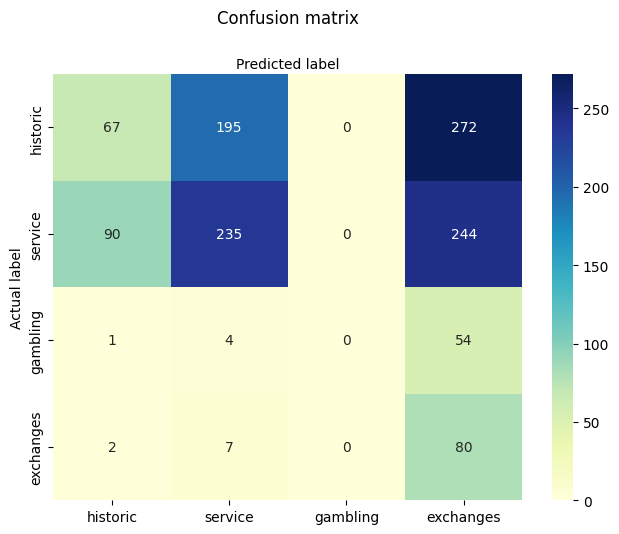

In [ ]:
# Logistic Regression Model Building

reg = LogisticRegression(C=10)
reg.fit(features_train, y_train)
y_predict = reg.predict(features_test)

# Model Evaluation
cnf_matrix = metrics.confusion_matrix(y_test, y_predict, labels=y_test['type'].unique())
heatmap = sns.heatmap(pd.DataFrame(cnf_matrix, index=y_test['type'].unique(), columns=y_test['type'].unique()), annot=True, cmap="YlGnBu" ,fmt='g')
heatmap.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Precision:",metrics.precision_score(y_test, y_predict, average='weighted'))
print("Recall:",metrics.recall_score(y_test, y_predict, average='weighted'))
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Precision: 0.5157513356975566
Recall: 0.4580335731414868
Accuracy: 0.4580335731414868


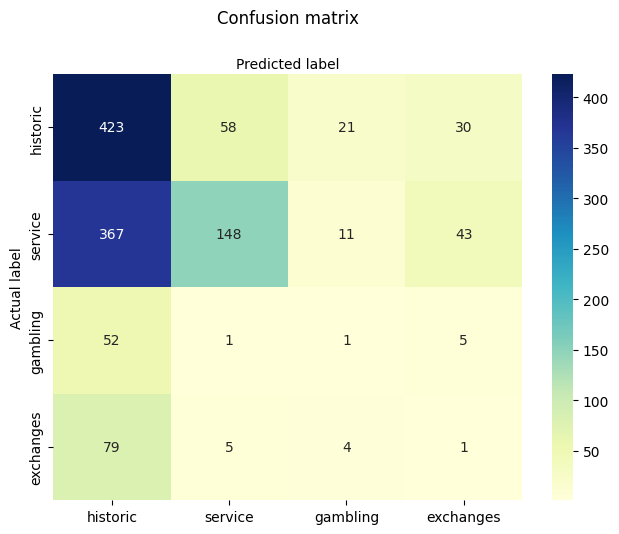

In [10]:
# Support Vector Machines Model Building

clf = svm.SVC(kernel='rbf', C=1000, gamma=0.9)   # Whatever is the best in the gridsearch
clf.fit(features_train, y_train)
y_predict = clf.predict(features_test)

# Model Evaluation

cnf_matrix = metrics.confusion_matrix(y_test, y_predict, labels=y_test['type'].unique())
heatmap = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
heatmap.xaxis.set_label_position("top")
heatmap.set_xticklabels(y_test['type'].unique())
heatmap.set_yticklabels(y_test['type'].unique())
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Precision:",metrics.precision_score(y_test, y_predict, average='weighted'))
print("Recall:",metrics.recall_score(y_test, y_predict, average='weighted'))
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

#### Discussion

**Model Exploration** - Using some of the features computed in Exercise 2, we explored two classification models - Logistic Regression and Support Vector Machines.
Logistic Regression will fit a logistic function on our data in a way that maximizes the probability that, given an input, an observation belongs to a certain class, while the Supoprt Vector Machines tries to find the hyperplane that best seperates the classes of data, by maximizing the margin to the nearest points. SVM in practice does this by mapping the data into higher dimensional spaces with a Kernel, such as linear, polynomial and Gaussian's Radial Basis Function kernels, with the new discrimants seperating the data and classifying it. Although we are predicting for 5 different labels, so in theory the Logistic Regresion would be less efficient than SVM since it is more useful in binary classification, we thought it was still worthwhile to explore this model since most of our data is labled as either service or historic, so it remains close to a binary case.

**Data Preparation** - Since this notebook was ran in Google Colab, due to its limited capabilities, a subset of 5000 random addresses was selected from the original features dataset, while keeping the native distribution of address types. Afterwards, the dataset was prepared by dividing it into training and testing data and standardizing the data. Note that standardization was done after the split in order to prevent the testing data from leaking to the training data in this process.

**Hyperparameters** - In the next step, the optimal hyperparameters were computed. Note that in our calculation, we made use of sklearn's Pipeline because GridSearch does its own train-test splits during cross validation, so Pipeline was used to ensure that the data was still normalized without data leakage. Also, the computations for the Support Vector Machines has less cross validations, since it is more computationally demanding due to the greater ammount of combinations of parameters tested. For the Logistic Regression, the optimal parameter for C was 1. C represents the level of regularization, which intruduces an added cost for complexity to the cost funcion our model is minimizing. A value of 1 means there is strong regularization, so the best performing model will be simpler. For the Support Vector Machines, a level of regularization C = 1000 was obtained, which suggests we will obtain a more complicated model. Additionally, the kernel using the Gaussian RBF, which is often used in SVM models, obtained the best performance. Finally, for the gamma, the RBF kernel uses an exponential function to map the data, and the gamma parameter determines how fastly the exponential function decays. In practice, higher gamma values will mean each training example will have more influence on the classification, resulting in a more overfitted model, while a lower gamma results in smoother discriminants and simpler models. We obtained a gamma of 0.9, meaning our model will be more overfit.

**Model Results** - After fitting both models to the training data set, using them to classify the testing data sets and evaluating with the existing classification, the confusion matrix and the Precision, Recall and Accuracy measures were computed. Comparing the two models, we can observe that the Precision, Recall and Accuracy are higher in the SVM model, with values of 51.58%, 45.8% and 45.8% respectively, compared with the LR's model 42.99%, 30.54% and 30.54%. To interpret these values, the Precision is the ratio of correct classifications out of all positive classifications, the Recall is the ratio of correct classifications out of all true classifications and the Accuracy is the ratio of all True Classifications (positive or negative) with all the observations. We can note, that although the SVM model is slightly better than the LR model (which was to be expected for the reasons mentioned in the beguinning), both models are of bad quality.
This is further supported by the confusion matrixes. For the first model, we can observe that thre is a big tendency to either classify addresses as exchanges or services, with some classification as historic and none on gambling and mining. The gambling and mining classification makes sense, as the number of entries were very limited, and mining was barely included in the training data. What was not expected was the model's tendency to assign the exchanges class with such a high frequency, which of course is not correct. For the second model, most of the classification is done as historic, with some as services, which were the two most common labels in the training data set. The fact that almost all addresses are classified as historic and also almost all of the data are either historic or service addresses, explains why the model's measures are closer to 50%, as the SVM model is most likely classifying correctly by chance, instead of capturing the differences between the addresses.

**Recommendations & Conclusions** From the previous results, we can conclude that the model measures are deceiving, as the SVM model seems better on the surface, but its higher measures are due to the frequent classification on one of the frequent labels. In order to improve these models in the future, the first steps would be to rethink the features selected for the model, and training with a more balanced distribution of labels, so that the model is not biased towards a specific set of labels.

## Exercise 4 [4 points]

Consider we didn't have the labels for the address, but that you would want to create groups of addresses. Propose a solution.


In [ ]:
# Data Preparation
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

statistics_ml_spark = spark.createDataFrame(statistics_ml_subset1.drop(['type'], axis=1))
assembler = VectorAssembler(inputCols=list(statistics_ml_spark.columns),outputCol="features")
datasetKM = assembler.transform(statistics_ml_spark)

Optimal Number Of Clusters: 2


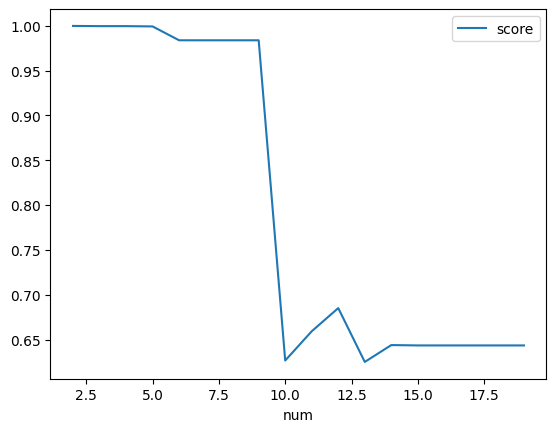

In [ ]:
# Hyperparameter Optimization
def evaluate( dataset, k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dataset)
    predictions = model.transform(dataset)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    return score

df = pd.DataFrame(columns=['num','score'])
for i in range(2,20):
    df = pd.concat([df,pd.Series({"num": i, "score": evaluate(datasetKM,i)}).to_frame().T], ignore_index=True)
df.plot( x="num", y="score")
print('Optimal Number Of Clusters:', int(df.nlargest(1,"score")["num"].values[0]))

Number Of Clusters: 2


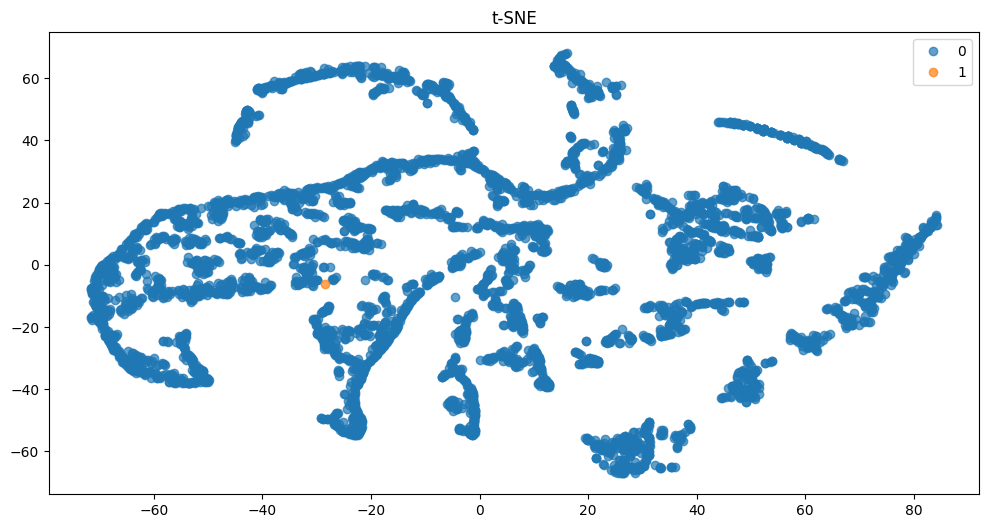

Quality of predictions (higher is better):0.9997805966279703


In [ ]:
# Clustering
k = int(df.nlargest(1,"score")["num"].values[0])
print('Number Of Clusters:', k)
kmeans = KMeans().setK(k).setSeed(seed)
model = kmeans.fit(datasetKM)
centers = model.clusterCenters()

predictions = model.transform(datasetKM)
predictionsPD = predictions.toPandas()

features = sklearnStandardScaler().fit_transform(predictionsPD.drop(['features'], axis=1).values)
reduced_tsne = TSNE(n_components=2).fit_transform(features)
plt.figure(figsize=(12,6))
for cluster in predictionsPD['prediction'].unique():
    mask = predictionsPD['prediction'] == cluster
    plt.plot(reduced_tsne[mask,0], reduced_tsne[mask,1], 'o', alpha=0.7, label=cluster)
plt.title('t-SNE')
plt.legend()
plt.show()


# Evaluate the quality of the prediction
evaluator = ClusteringEvaluator()
score = evaluator.evaluate(predictions)

print( "Quality of predictions (higher is better):" + str(score))

#### Discussion

**Model Explanation** In order to group the addresses without having access to the previously done classification, we implemented the KMeans clustering algorithm. In practice, this algorithm will start off by selecting K random points, with k being the number of specified clusters. These random points are the initial centers of the clusters, or centroids. Next, each datapoint is assigned to the closest centroid (based on Euclidean distance), and the cluster centroid is updated, computed as the mean of the cluster's points. Then this process repeats, until we reach a state of convergence where the centroids no longer change significantly.

**Hyperparameter Optimization** - In order to decide the number of clusters, we tested the Solhouette Scores for K values 2 to 40, and arrived at 2 as the best number.

**Results Evaluation** Afterwards, we clustered the data, using k=2, and obtained a Silhouette Score of 0.9998. The Score obtained is extremely high, is very low and the features computed don't differentiate the data enough to justify a higher number of clusters. This must mean that our algorithm ended up assigining most of the data points to one cluster, while assigining few points to the other, which artifically boosts the score obtained. To visualize the result, t-SNE dimensionality reduction was applied to the input data and the clusters were applied on top as colors which confirmed the previous statement. Note that t-SNE was chosen in order to preserve the local relationships within the clusters but, since the clustering process produced bad results, the scatter plot looks odd.

It is important to mention that we did try to perfor the clustering algorythm with a higher value of k, for example, k=4 but the results were not much better and the clusters were still very small appart from the one to which most of the datapoints were assigned. This only leads to the conclusion that there is a fault with the features selected or the training data.

**Recommendations & Conclusions** From the model obtained, we can confirm that new features that can better differentiate the addresses are needed in order to build quality model. Also, we must consider that the training data does not have an equal representation of the different types of addresses, so it is normal for one cluster to include most of the data. Finally, our results also showcase how sensible the KMeans algorithm is to outliers, so we can improve the training data by removing them.

## Exercise 5 [3+1 points]

Propose a problem to solve and implement it (for 3 points).

Use cuDF/cuML/cuGrpahs for 1 extra point.

In [20]:
# Do clustering with every month

path = os.path.join(DATASET_DIR, BTCPRICE_FILE)
# pdf = pd.read_csv(path)

cdf = cudf.read_csv(path)
cdf["Date"] = cudf.to_datetime(cdf["Date"])
# cdf["Month"] = cdf["Date"].dt.month
cdf["YearMonth"] = cdf["Date"].dt.strftime("%Y-%m")
cdf = cdf.sort_values(by="Date")

# Average, min and max
priceStatistics = cdf.groupby("YearMonth").agg({
    "Price": ["mean", "median", "max", "min"]
}).reset_index()
priceStatistics.columns = ["_".join(col).strip() if col[1] else col[0] for col in priceStatistics.columns.values]

# Price Delta
first_last_price = cdf.groupby("YearMonth")["Price"].agg(["first", "last"]).reset_index()
first_last_price["Price_delta"] = first_last_price["last"] - first_last_price["first"]
first_last_price.rename(columns={"first": "First_Price", "last": "Last_Price"}, inplace=True)
priceStatistics = priceStatistics.merge(first_last_price[["YearMonth", "Price_delta"]], on="YearMonth", how="left")

# Price Variance
monthly_variance = cdf.groupby("YearMonth")["Price"].var()
monthly_variance_df = monthly_variance.reset_index()
monthly_variance_df.columns = ["YearMonth", "Price_variance"]
priceStatistics = priceStatistics.merge(monthly_variance_df, on="YearMonth")

# Standard Deviation
monthly_std = cdf.groupby("YearMonth")["Price"].std()
monthly_std_df = monthly_std.reset_index()
monthly_std_df.columns = ["YearMonth", "Price_standard_deviation"]
priceStatistics = priceStatistics.merge(monthly_std_df, on="YearMonth")

# Trend Changes
cdf["PriceChange"] = cdf["Price"] - cdf["Price"].shift(1)
cdf["Direction"] = (cdf["PriceChange"] > 0).astype(int) - (cdf["PriceChange"] < 0).astype(int)
cdf["Direction"] = cdf["Direction"].fillna(0).astype("int32")

trend_changes = []

def calculate_trend_changes(group):
  return ((group["Direction"].diff()).abs() > 0).sum()

grouped = cdf.groupby("YearMonth")
for key, group in grouped:
    trend_changes.append({"YearMonth": key, "Price_trend_changes": calculate_trend_changes(group)})

trend_changes_df = cudf.DataFrame(trend_changes)

priceStatistics = priceStatistics.merge(trend_changes_df, on="YearMonth")

priceStatistics = priceStatistics.sort_values("YearMonth").reset_index(drop=True)

cdf = cdf.sort_values(by="Date")
# display(cdf)
display(priceStatistics)

columns_to_scale = ["Price_mean", "Price_median", "Price_max", "Price_min", "Price_delta", "Price_variance", "Price_standard_deviation", "Price_trend_changes"]
temporary = priceStatistics[columns_to_scale].copy()
scaler = cuStandardScaler()
scaler.fit(temporary)
filtered = scaler.transform(temporary)
filtered.columns = columns_to_scale
display(filtered)

,YearMonth,Price_mean,Price_median,Price_max,Price_min,Price_delta,Price_variance,Price_standard_deviation,Price_trend_changes
0,2009-01,0.100000,0.1,0.1,0.1,0.0,2.046301e-34,1.430490e-17,0
1,2009-02,0.100000,0.1,0.1,0.1,0.0,1.797535e-33,4.239734e-17,0
2,2009-03,0.100000,0.1,0.1,0.1,0.0,1.791115e-33,4.232156e-17,0
3,2009-04,0.100000,0.1,0.1,0.1,0.0,1.793107e-33,4.234510e-17,0
4,2009-05,0.100000,0.1,0.1,0.1,0.0,1.791115e-33,4.232156e-17,0
...,...,...,...,...,...,...,...,...,...
174,2023-07,30056.380645,30139.7,31466.1,29178.1,-1354.4,3.526568e+05,5.938491e+02,17
175,2023-08,27866.067742,28726.3,29777.4,25937.3,-3774.9,2.432462e+06,1.559635e+03,15
176,2023-09,26307.326667,26277.1,27209.2,25166.4,1159.5,2.384085e+05,4.882709e+02,15
177,2023-10,29748.264516,28321.7,34650.6,26761.1,6676.1,8.848565e+06,2.974654e+03,14


,Price_mean,Price_median,Price_max,Price_min,Price_delta,Price_variance,Price_standard_deviation,Price_trend_changes
0,-0.621227,-0.617664,-0.622948,-0.619994,-0.041670,-0.292308,-0.552127,-2.324864
1,-0.621227,-0.617664,-0.622948,-0.619994,-0.041670,-0.292308,-0.552127,-2.324864
2,-0.621227,-0.617664,-0.622948,-0.619994,-0.041670,-0.292308,-0.552127,-2.324864
3,-0.621227,-0.617664,-0.622948,-0.619994,-0.041670,-0.292308,-0.552127,-2.324864
4,-0.621227,-0.617664,-0.622948,-0.619994,-0.041670,-0.292308,-0.552127,-2.324864
...,...,...,...,...,...,...,...,...
174,1.481448,1.484854,1.304621,1.717407,-0.459184,-0.245579,-0.095403,0.519752
175,1.328218,1.386256,1.201173,1.457792,-1.205341,0.030009,0.647373,0.185092
176,1.219172,1.215402,1.043848,1.396036,0.315764,-0.260718,-0.176603,0.185092
177,1.459893,1.358032,1.499699,1.523785,2.016342,0.880184,1.735650,0.017761


In [19]:
start_time = time.time()

for clusters in range(2, 40):
  print("clusters:", clusters)
  model = cuml.cluster.KMeans(n_clusters=clusters, max_iter=30, n_init=1,init='k-means||')
  model.fit(filtered)

  #using silhouette
  cluster_labels = model.labels_
  silhouette_avg = cusilhouette_score(filtered, cluster_labels)
  print("Silhouette Score =", silhouette_avg)

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

clusters: 2
Silhouette Score = 0.633886672166342
clusters: 3
Silhouette Score = 0.5917246037916187
clusters: 4
Silhouette Score = 0.5975103797822738
clusters: 5
Silhouette Score = 0.5201370347042917
clusters: 6
Silhouette Score = 0.5135104968689014
clusters: 7
Silhouette Score = 0.561967791401854
clusters: 8
Silhouette Score = 0.49034311694818417
clusters: 9
Silhouette Score = 0.48784802484024536
clusters: 10
Silhouette Score = 0.4687945226580452
clusters: 11
Silhouette Score = 0.4850842404694883
clusters: 12
Silhouette Score = 0.48221926705615975
clusters: 13
Silhouette Score = 0.4604085921669238
clusters: 14
Silhouette Score = 0.451323291350264
clusters: 15
Silhouette Score = 0.4538687397765436
clusters: 16
Silhouette Score = 0.4200680639734856
clusters: 17
Silhouette Score = 0.4322893486086893
clusters: 18
Silhouette Score = 0.43662887234145453
clusters: 19
Silhouette Score = 0.4296198019735313
clusters: 20
Silhouette Score = 0.4313835633861703
clusters: 21
Silhouette Score = 0.4274

With this information, we might want to do clustering with k=7 so that we get a representative number of clusters and a still decent silhouetter score, withint what is possible here.

#### Discussion

**Explain your code and discuss results**

We propose the exercise of performing clustering on the months, based on the information that is possible to gather from the changes in bitcoin price over the years. We do this within the broader scope of possibily being able to group months in order to better understand the market when speculating.

We created the following statistics for each month:

*Price Mean*: The Price Mean represents the average Bitcoin price for a given month, offering insights into the typical price level during that period.

*Price Median*: The Price Median is the middle value in a sorted list of prices for a month, providing a central value less affected by outliers.

*Price Max*: The Price Max reveals the highest recorded Bitcoin price within a month, helping identify peak price levels.

*Price Min*: The Price Min signifies the lowest recorded Bitcoin price within a month, highlighting price floors and bottoms.

*Price Delta*: The Price Delta measures the price change between the first and last recorded prices in a month, quantifying overall price movement.

*Price Variance*: Price Variance measures the spread of Bitcoin prices within a month, offering insights into price volatility and variability.

*Price Standard Deviation*: The Price Standard Deviation quantifies the average deviation of prices from the mean, complementing variance as a measure of price volatility.

*Price Trend Changes*: Price Trend Changes count shifts in price direction within a month, revealing market dynamics and the frequency of trend reversals.

**Clustering**

For k=2, we achieved a relatively high Silhouette Score of 0.6339, indicating that the data points are well-clustered when grouped into two clusters.

As we increased the number of clusters to 3 and 4, the Silhouette Scores remained relatively high (around 0.59-0.60), suggesting that these configurations also provide good clustering solutions.

However, as you further increased the number of clusters beyond 4, the Silhouette Scores started to decrease. This suggests that splitting the data into more clusters may not necessarily result in better clustering quality, and it might lead to less distinct or overlapping clusters. The only exception might be k=7 with a relatively nice score of 0.56.

The decreasing Silhouette Scores continue as we go up to 40 clusters, with scores dropping below 0.5.

Based on these results, one might consider using a lower number of clusters, such as 2, 3, or 4, depending on the specific requirements of your analysis.